In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.ndimage import gaussian_filter1d

In [ ]:
# Load SNV predictions
snv_df = pd.read_csv('../data/example_snv_predictions.csv')
snv_df

,id,chr,pos,ref,alt,signal_true,signal_pred_ref,signal_pred_alt
0,.,chr2,88308342,G,A,"[0.6376953125, 0.6376953125, 0.6376953125, 0.6...","[[0.03421616926789284], [0.031020237132906914]...","[[0.03418124467134476], [0.030983153730630875]..."
1,.,chr3,67154587,G,A,"[0.07257080078125, 0.07257080078125, 0.0725708...","[[0.0133963106200099], [0.01454814150929451], ...","[[0.013378416188061237], [0.014499758370220661..."
2,.,chr3,136567719,C,T,"[0.07257080078125, 0.07257080078125, 0.0042381...","[[0.09514357894659042], [0.07829154282808304],...","[[0.09493541717529297], [0.07814227789640427],..."
3,.,chr12,42545577,G,T,"[0.0008897781372070312, 0.0008897781372070312,...","[[0.029238834977149963], [0.03743935748934746]...","[[0.029086455702781677], [0.03722166270017624]..."
4,.,chr13,94711393,G,A,"[6.0234375, 6.0234375, 6.0234375, 6.0234375, 6...","[[0.03146391734480858], [0.02670384757220745],...","[[0.03129521757364273], [0.026601281017065048]..."


In [3]:
def flatten(list2d):
    # flatten 2D list to 1D list
    return [x for y in list2d for x in y]

def calculate_score(ref_list, alt_list, ref_over_var: bool, log_fc: bool = False):
    # extract signal over mutation position 
    n = len(ref_list)
    start, end = (n // 2), (n // 2 + 1)
    ref_list = ref_list[start:end]
    alt_list = alt_list[start:end]

    # calculate fold change
    delta = 1e-4
    if ref_over_var:
        score = sum(ref_list) / (sum(alt_list)+delta)
    else:
        score = sum(alt_list) / (sum(ref_list)+delta)
    if log_fc:
        score = np.log2(score + 1)
    
    # round to 3 decimal places
    return round(score, 3)


def smooth(y, sigma=8):
    # apply gaussian smoothing
    return gaussian_filter1d(np.array(y), sigma)

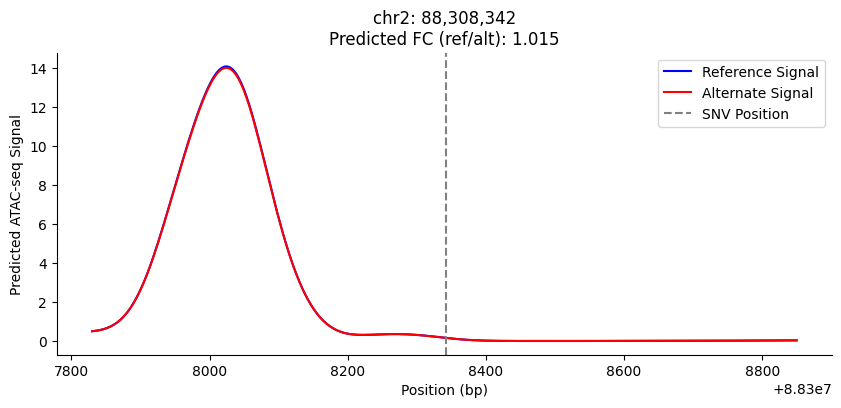

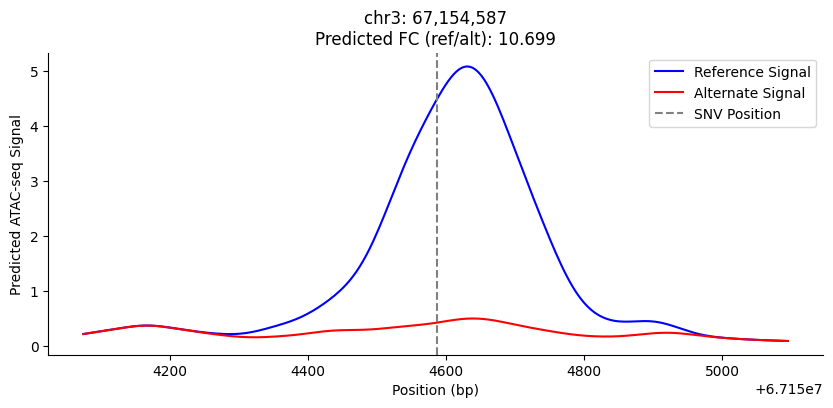

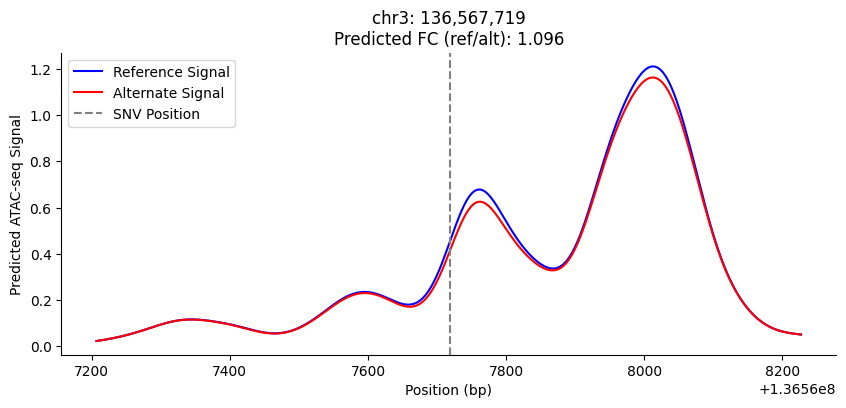

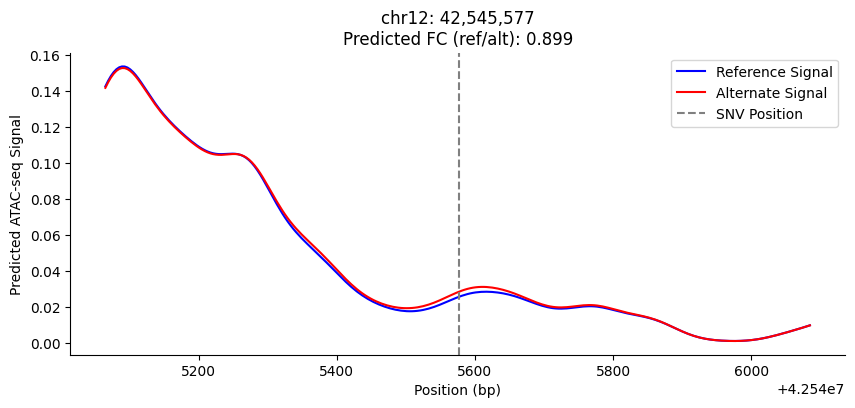

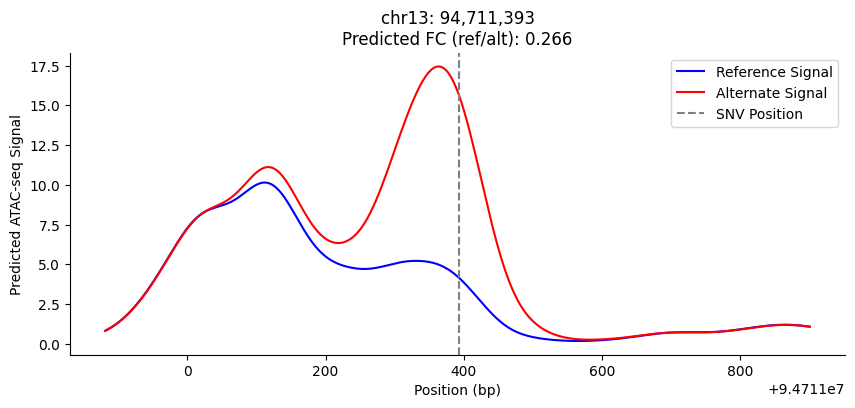

In [4]:
window_size = 1024 # central 1024bp region
bin_size = 4  # 4bp resolution

for index, row in snv_df.iterrows():
    # plot signal_pred_ref and signal_pred_alt for each SNV
    ref_list = flatten(json.loads(row['signal_pred_ref']))
    alt_list = flatten(json.loads(row['signal_pred_alt']))

    ref_list = np.exp(ref_list)-1
    alt_list = np.exp(alt_list)-1

    # smooth the predictions as 4bp is very noisy and we treat the smoothed signal as final prediction
    ref_list = smooth(ref_list)
    alt_list = smooth(alt_list)

    # select only the central 1024bp region for plotting
    center = len(ref_list) // 2
    half_window = (window_size // 2)// bin_size
    ref_list = ref_list[center - half_window:center + half_window]
    alt_list = alt_list[center - half_window:center + half_window]

    # establish x-axis labels
    x_labels = np.arange(-half_window*bin_size, half_window*bin_size, bin_size)
    x_labels = x_labels+ row['pos']  # adjust x-axis to genomic position

    # calculate fold change and plot
    fc = calculate_score(ref_list, alt_list, ref_over_var=True, log_fc=False)
    
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(x_labels, ref_list, label='Reference Signal', color='blue')
    plt.plot(x_labels, alt_list, label='Alternate Signal', color='red')
    plt.axvline(x=row['pos'], color='gray', linestyle='--', label='SNV Position')
    plt.title(str(row['chr']) + ': ' + f'{row["pos"]:,}' + '\nPredicted FC (ref/alt): ' + str(fc))
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Position (bp)')
    plt.ylabel('Predicted ATAC-seq Signal')

    plt.legend()
    plt.show()
    